# Predicting Airbnb Price per Night

> Matteo Perona

In [380]:
import pandas as pd
import numpy as np

df = pd.read_csv('train.csv')

/var/folders/vb/08bw66p50l7fsmzng9tj5m9h0000gn/T/ipykernel_73637/1205505852.py:4: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train.csv')


## Exploring the Data

In [13]:
df.shape

(33538, 65)

Let's look at the first column to get a better idea of what each feature is telling us. 

In [11]:
for item in df.iloc[0].items():
    print(f'{item[0]}: {item[1]}')

id: 22267382
name: Modern and Cozy Large Studio in Brooklyn
summary: Modern large studio with new amenities and appliances on the 40th floor in Brooklyn, 10 - 15 min from Manhattan by subway, all major subways close by, Fort Greene Park, BAM, Barclay Center, great restaurants. Washer/Dryer available in the unit. Gym available in the building at no additional cost
space: Our place is a little quiet sanctuary in the heart of Fort Greene. Amazing views from the apartment and common area on the 41st floor. Looking for respectful guests, singles/couples, who'll treat this home as theirs. *The studio available is almost identical to the one in pics, but slightly smaller. The rest of the information is the same.That's why we are offering an additional discount.
description: Modern large studio with new amenities and appliances on the 40th floor in Brooklyn, 10 - 15 min from Manhattan by subway, all major subways close by, Fort Greene Park, BAM, Barclay Center, great restaurants. Washer/Dryer 

### Preliminary Cleaning

Immediately we can tell that the following will not be useful for predictions because they are either redundant or do not provide any information that could be used to enhance predictions:
* id - (does not add infromation)
* host_name - (redundant with host_id which has fewer missing values)
* country, country_code - (redundant, all entries should be from the US)
* state - (redundant, state should always be NY)
* market - (redundant, should always be Ney York)

In [95]:
# Sanity check that all ids are unique 
df.id.unique().shape[0] == df.shape[0]

True

We'll create a cleaned version of the df that we'll update as we explore.

In [110]:
df_cleaned = df.drop(['id', 'host_name'], axis=1)

Before removing country, country_code, state, and market, we need to dig deeper to see if there is any inconsistency in the data. 

In [111]:
df.country.unique(), df.country_code.unique()

(array(['United States', 'Uruguay'], dtype=object),
 array(['US', 'UY'], dtype=object))

In [112]:
df[df.country == 'Uruguay']

,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
7576,6645634,New unit in the heart of Manhatten,Brand new one bedroom apartment right on Manha...,NaN,Brand new one bedroom apartment right on Manha...,none,NaN,NaN,NaN,NaN,...,9.0,9.0,9.0,f,f,strict_14_with_grace_period,f,f,1,0.06


Looks like there's only one row with incorrect country. Its values are mostly null so I'm removing it from the data.

In [113]:
df_cleaned = df_cleaned.drop(7576)
# Sanity check that drop worked
df_cleaned.country.unique()

array(['United States'], dtype=object)

In [114]:
# Remove the country features 
df_cleaned = df_cleaned.drop(['country', 'country_code'], axis=1)

Let's see if there are any of the same inconsistencies with state. 

In [118]:
unique_state = df.state.unique()
unique_state

array(['NY', 'Ny', 'New York', nan, 'MP', 'NJ', 'ny', 'CA'], dtype=object)

It looks like New York is referred to under multiple different names. Let's reduce to NY:

In [123]:
df_cleaned.state = df_cleaned.state.apply(lambda x: 'NY' if x in ['NY', 'Ny', 'New York', 'ny'] else x)
# Sanity check 
df_cleaned.state.unique()

array(['NY', nan, 'MP', 'NJ', 'CA'], dtype=object)

Now lets see what rows have other states listed.

In [147]:
df_cleaned[df_cleaned.state == 'MP'].index, \
df_cleaned[df_cleaned.state == 'CA'].index, \
df_cleaned[df_cleaned.state == 'NJ'].index

(Index([19125], dtype='int64'),
 Index([27194], dtype='int64'),
 Index([20228], dtype='int64'))

It looks like there are only 3 rows, so let's just remove them.

In [155]:
df_cleaned = df_cleaned.drop([19125, 27194, 20228])
# Sanity check
df_cleaned.state.unique()

array(['NY', nan], dtype=object)

In [167]:
df_cleaned = df_cleaned.drop('state', axis=1)

Finally lets look into market.

In [156]:
df.market.unique()

array(['New York', nan, 'Catskills and Hudson Valley', 'Boston',
       'Other (Domestic)', 'Los Angeles', 'San Francisco',
       'Jamaica South Coast', 'New Orleans', 'Adirondacks', 'Agra',
       'Paris', 'Kyoto'], dtype=object)

In [163]:
non_ny_market_idx = df[df.market != 'New York'].index
len(non_ny_market_idx)

113

In [168]:
df_cleaned = df_cleaned.drop(non_ny_market_idx)
# Sanity Check 
df_cleaned.market.unique()

array(['New York'], dtype=object)

In [170]:
df_cleaned = df_cleaned.drop('market', axis=1)

We've removed all 6 features we wanted to purge. Let's check that the featue count went from 65 to 59.

In [174]:
df_cleaned.shape[1] == 59

True

### Data Types

In [28]:
for item in df.dtypes.sort_values().items():
    print(f'{item[1]} : {item[0]}')

int64 : id
int64 : accommodates
int64 : host_id
int64 : guests_included
int64 : calculated_host_listings_count
int64 : maximum_nights
int64 : number_of_reviews
int64 : minimum_nights
float64 : review_scores_accuracy
float64 : review_scores_cleanliness
float64 : review_scores_checkin
float64 : review_scores_communication
float64 : review_scores_location
float64 : price
float64 : square_feet
float64 : beds
float64 : bedrooms
float64 : bathrooms
float64 : review_scores_value
float64 : review_scores_rating
float64 : host_listings_count
float64 : reviews_per_month
float64 : host_acceptance_rate
object : interaction
object : access
object : transit
object : first_review
object : last_review
object : notes
object : neighborhood_overview
object : experiences_offered
object : extra_people
object : host_is_superhost
object : space
object : summary
object : name
object : instant_bookable
object : is_business_travel_ready
object : cancellation_policy
object : require_guest_profile_picture
object :

In [252]:
# Create lists of numeric and non-numeric features
numeric_features = df.select_dtypes(include=['number']).columns.tolist()
non_numeric_features =  [f for f in df.columns if f not in numeric_features]

#### Find Non-Numeric Features that Could be Numeric and Reformat

In [361]:
numeric_features_cleaned = df_cleaned.select_dtypes(include=['number']).columns.tolist()
non_numeric_features_cleaned =  [f for f in df_cleaned.columns if f not in numeric_features]

df_cleaned[non_numeric_features_cleaned].iloc[1034]

name                                 Charming, Colorful One Bedroom In Hell's Kitchen
summary                             Indulge yourselves in our lovely apartment loc...
space                               Charmingly colorful one bedroom apartment in H...
description                         Indulge yourselves in our lovely apartment loc...
neighborhood_overview               Our apartment is located in a peaceful, safe b...
notes                               If you need a late checkout, or somewhere to t...
transit                             Subway: This is an incredibly convenient locat...
access                              This is a private apartment so you’ll full acc...
interaction                         I am available 24/7 for any questions you have...
house_rules                                                                       NaN
host_since                                                               1533452400.0
host_location                                         

##### Dates $\to$ Unix

In [302]:
from datetime import datetime

date_features = ['host_since', 'first_review', 'last_review']

for i in range(len(date_features)):
    df_cleaned[date_features[i]] = df_cleaned[date_features[i]].apply(lambda x: \
        datetime.strptime(x, '%Y-%m-%d').timestamp() \
        if x is not np.nan else x)

df_cleaned[date_features]

,host_since,first_review,last_review
0,1.331536e+09,1.514794e+09,1.530601e+09
1,1.379142e+09,1.397545e+09,1.540019e+09
2,1.355213e+09,1.532588e+09,1.539500e+09
3,1.386058e+09,NaN,NaN
4,1.336720e+09,1.422691e+09,1.539760e+09
...,...,...,...
33533,1.340003e+09,1.428908e+09,1.477292e+09
33534,1.440140e+09,1.443424e+09,1.540624e+09
33535,1.336028e+09,NaN,NaN
33536,1.404630e+09,1.515226e+09,1.515226e+09


##### Bool $\to$ Binary

In [331]:
bool_features = [
    'require_guest_phone_verification', 
    'require_guest_profile_picture', 
    'is_business_travel_ready',
    'instant_bookable',
    'host_identity_verified',
    'host_has_profile_pic',
    'host_is_superhost']

for i in range(len(bool_features)):
    df_cleaned[bool_features[i]] = df_cleaned[bool_features[0]] \
        .apply(lambda x: x=='t' or x==True if x is not np.nan else x)
    
df_cleaned[bool_features]

,require_guest_phone_verification,require_guest_profile_picture,is_business_travel_ready,instant_bookable,host_identity_verified,host_has_profile_pic,host_is_superhost
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
33533,False,False,False,False,False,False,False
33534,False,False,False,False,False,False,False
33535,False,False,False,False,False,False,False
33536,False,False,False,False,False,False,False


#### What's left?

In [362]:
non_numeric_features_cleaned_2 = list(
    set(non_numeric_features_cleaned) - set(date_features + bool_features))
df_cleaned[non_numeric_features_cleaned_2].iloc[100]

host_response_rate                                                            1.0
host_about                      I am a PhD candidate in Art History and an ind...
access                          You have access to everything in the house exc...
bed_type                                                                 Real Bed
extra_people                                                                 50.0
amenities                       {TV,Wifi,"Air conditioning",Kitchen,"Free stre...
summary                         I am an artist from Chile and often travel abr...
cancellation_policy                                                      moderate
notes                           The main key for the door serves for both cyli...
room_type                                                            Private room
neighbourhood_cleansed                                                   Bushwick
host_verifications              ['email', 'phone', 'reviews', 'jumio', 'offlin...
zipcode         

#### String $\to$ Number

The only two features that fit this criterion are host_response_rate and extra_people.

They each require different logic so they will be processed independently. 

In [354]:
# Converts host_response_rate from strings representing percentages to proportions.
df_cleaned['host_response_rate'] = df_cleaned['host_response_rate'].apply(
    lambda x: float(x.replace('%',''))/100 if x is not np.nan else x)

df_cleaned['host_response_rate']

0         NaN
1        1.00
2        1.00
3         NaN
4        1.00
         ... 
33533     NaN
33534     NaN
33535     NaN
33536    1.00
33537    0.92
Name: host_response_rate, Length: 33421, dtype: float64

In [357]:
# Converts extra_people from strings representing prices to floats.
df_cleaned['extra_people'] = df_cleaned['extra_people'].apply(
    lambda x: float(x.replace('$','')) if x is not np.nan else x)
df_cleaned['extra_people']

0        30.0
1        19.0
2         0.0
3         0.0
4        14.0
         ... 
33533    25.0
33534     0.0
33535     0.0
33536     0.0
33537    25.0
Name: extra_people, Length: 33421, dtype: float64

#### One-Hot Encoding

In [363]:
non_numeric_features_cleaned_3 = list(
    set(non_numeric_features_cleaned_2) - set(['host_response_rate','extra_people']))
df_cleaned[non_numeric_features_cleaned_3].iloc[100]

host_about                      I am a PhD candidate in Art History and an ind...
access                          You have access to everything in the house exc...
bed_type                                                                 Real Bed
zipcode                                                                   11221.0
city                                                                     Brooklyn
neighborhood_overview           It is closed to cool restaurants such as Rober...
interaction                     You can contact me at any time through this pl...
summary                         I am an artist from Chile and often travel abr...
amenities                       {TV,Wifi,"Air conditioning",Kitchen,"Free stre...
name                                         Beautiful large 2 bedroom @ Bushwick
cancellation_policy                                                      moderate
host_neighbourhood                                                       Bushwick
host_response_ti

To better understand which features should be one hot encoded let's assess the number of unique values. If a feature has lots of unique values it's a bad candidate for one-hot encoding. However, if a feature describes some discrete finite set of possibilites one-hot can work well. 

In [373]:
feature_unique_counts = {
    'feature': [],
    'unique_count': [],
}

for feature in non_numeric_features_cleaned_3:
    unique_count = len(df[feature].unique())
    feature_unique_counts['feature'].append(feature)
    feature_unique_counts['unique_count'].append(unique_count)
    # print(f'{feature}: {unique_count}')

feature_unique_counts = pd.DataFrame(feature_unique_counts) \
    .sort_values(by='unique_count').reset_index(drop=True)

feature_unique_counts

,feature,unique_count
0,room_type,3
1,bed_type,5
2,neighbourhood_group_cleansed,5
3,host_response_time,5
4,cancellation_policy,7
5,property_type,29
6,neighbourhood_cleansed,220
7,city,242
8,host_neighbourhood,356
9,host_verifications,458


One can see a sharp increase after index 11 between host_location and notes. Looking more subjectively at the data, this point seems to correspond with the division between one-hot encodable data and those data which are not good candidates for one-hot encoding. 

In [385]:
df.host_verifications.unique()

array(["['email', 'phone', 'reviews', 'jumio', 'government_id']",
       "['email', 'phone', 'reviews', 'manual_offline']",
       "['email', 'phone', 'facebook', 'reviews', 'kba']",
       "['email', 'phone', 'reviews', 'kba']",
       "['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'sent_id', 'selfie', 'government_id', 'identity_manual']",
       "['email', 'phone', 'reviews', 'kba', 'work_email']",
       "['email', 'phone']",
       "['email', 'phone', 'reviews', 'jumio', 'government_id', 'work_email']",
       "['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'government_id', 'work_email']",
       "['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'government_id']",
       "['email', 'phone', 'reviews']",
       "['email', 'phone', 'reviews', 'jumio', 'offline_government_id', 'selfie', 'government_id', 'identity_manual']",
       "['email', 'phone', 'facebook', 'reviews', 'kba', 'work_email']",
       "['email', 'phone', 'reviews', 'o

In [390]:
df.city.unique()

array(['Brooklyn', 'New York', 'Queens', 'Staten Island', 'Flushing',
       'Bronx', 'Williamsburg', 'Long Island City', 'Staten zIsland',
       'Bronx ', 'flushing', 'Brooklyn ', 'Sunnyside, Queens', 'Astoria',
       'Springfield Gardens', 'astoria', 'Bklyn NY', 'Neponsit',
       'Forest Hills', 'New York City', 'Jackson heights', nan,
       'Astoria ', 'Woodhaven ', 'Maspeth', 'Woodside', 'Staten Island ',
       'Flushing ', 'LIC', 'Jamaica', 'Sunnyside ', 'Ridgewood',
       'Chelsea, New York', 'nyc', 'NYC ', 'South Richmond Hill', '纽约',
       'East Elmhurst ', 'Elmhurst ', '8425 Elmhurst avenue ', 'Corona',
       'NY', 'Woodside ', 'Rockaway beach', 'New York ',
       'Long Island City ', 'Far Rockaway', 'bronx', 'Riverdale ',
       'Queens ', 'New-York', 'Nyc', 'Kew Gardens ', 'Long Island city',
       'Whitestone ', 'Ridgewood ', 'Astoria Queens ', 'Jackson heights ',
       'Howard Beach', 'Bellerose', '纽约市', 'FOREST HILLS',
       'Forest Hills ', 'Clinton Hill Broo

In [382]:
# Leaving out hose
one_hot_features = feature_unique_counts.iloc[0:11].feature
one_hot_features

0                        room_type
1                         bed_type
2     neighbourhood_group_cleansed
3               host_response_time
4              cancellation_policy
5                    property_type
6           neighbourhood_cleansed
7                             city
8               host_neighbourhood
9               host_verifications
10                         zipcode
Name: feature, dtype: object

In [383]:
pd.get_dummies(df, columns=one_hot_features)

,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,...,zipcode_11559,zipcode_11691,zipcode_11691.0,zipcode_11692,zipcode_11692.0,zipcode_11693,zipcode_11693.0,zipcode_11694,zipcode_11694.0,zipcode_91766.0
0,22267382,Modern and Cozy Large Studio in Brooklyn,Modern large studio with new amenities and app...,Our place is a little quiet sanctuary in the h...,Modern large studio with new amenities and app...,none,"BAM, Barclays, Brooklyn City Point, Fort Green...",NaN,"Subway: 2,3,4,5,A,C,B,Q,G",Washer/Dryer Dishwasher Internet Gym Roof Top ...,...,False,False,False,False,False,False,False,False,False,False
1,2473861,Royal Harlem TRIPLEX Home 5 Beds,Harlem is back and so gorgeous! Visit and expl...,Harlem is back and so gorgeous! Visit and expl...,Harlem is back and so gorgeous! Visit and expl...,none,HARLEM is a piece of real NY history overflowi...,HARLEM RESTAURANTS Red Rooster Harlem -- excel...,PUBLIC TRANSPORTATION: Conveniently near all p...,The WHOLE ENTIRE HOUSE,...,False,False,False,False,False,False,False,False,False,False
2,25079703,Sunny East Village Studio,"Clean, hip and well designed sun drenched East...",This is a rare East Village studio with it's h...,"Clean, hip and well designed sun drenched East...",none,East Village is one of the last remaining neig...,NaN,NaN,You'll have access to the entire space - it's ...,...,False,False,False,False,False,False,False,False,False,False
3,9342478,"Beautiful, airy, light-filled room","Private, spacious, comfortable room in 2-bed f...","Big closet, two big windows, tall ceiling and ...","Private, spacious, comfortable room in 2-bed f...",none,One block from Morgan L stop. Super cool area....,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
4,4866426,Private Room in Prime Brooklyn Spot,"Comfy, quiet and big private room in a three b...",This big old apartment that we love and take c...,"Comfy, quiet and big private room in a three b...",none,I absolutely love this neighborhood - right at...,Just a note about the space: The window in you...,Super convenient to almost all subway lines. A...,Your room has a very comfortable queen sized b...,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33533,3958032,Private Room Amazing View in EV,"Private room in cozy, sun-drenched & plant fil...",NaN,"Private room in cozy, sun-drenched & plant fil...",none,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
33534,7987209,Floor 35th in the heart of New York,This is a beautiful four bedroom and three bat...,This is a Duplex Apartment (2 floors) Main Flo...,This is a beautiful four bedroom and three bat...,none,LOCATION LOCATION LOCATION. Walk to Time Squar...,NaN,Apartment is located at 70 W 45th Street (betw...,Access to the unit is through elevators.,...,False,False,False,False,False,False,False,False,False,False
33535,796128,Cozy room for rent in duplex house,NaN,Room for rent in duplex house located in Astor...,Room for rent in duplex house located in Astor...,none,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
33536,17281121,"Beautiful 1 bedroom apart, Washington Heights",Very spacious bright beautiful apartment in Wa...,"Very spacious living room, bright kitchen with...",Very spacious bright beautiful apartment in Wa...,none,Very close to Times Square but a quiet residen...,NaN,Very Close to subway lines A and 1 trains. Les...,"Living room, bedroom, shared kitchen and bathr...",...,False,False,False,False,False,False,False,False,False,False


### Missing Values

/var/folders/vb/08bw66p50l7fsmzng9tj5m9h0000gn/T/ipykernel_73637/820464109.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prop_missing, y=prop_missing.index, palette='rocket')


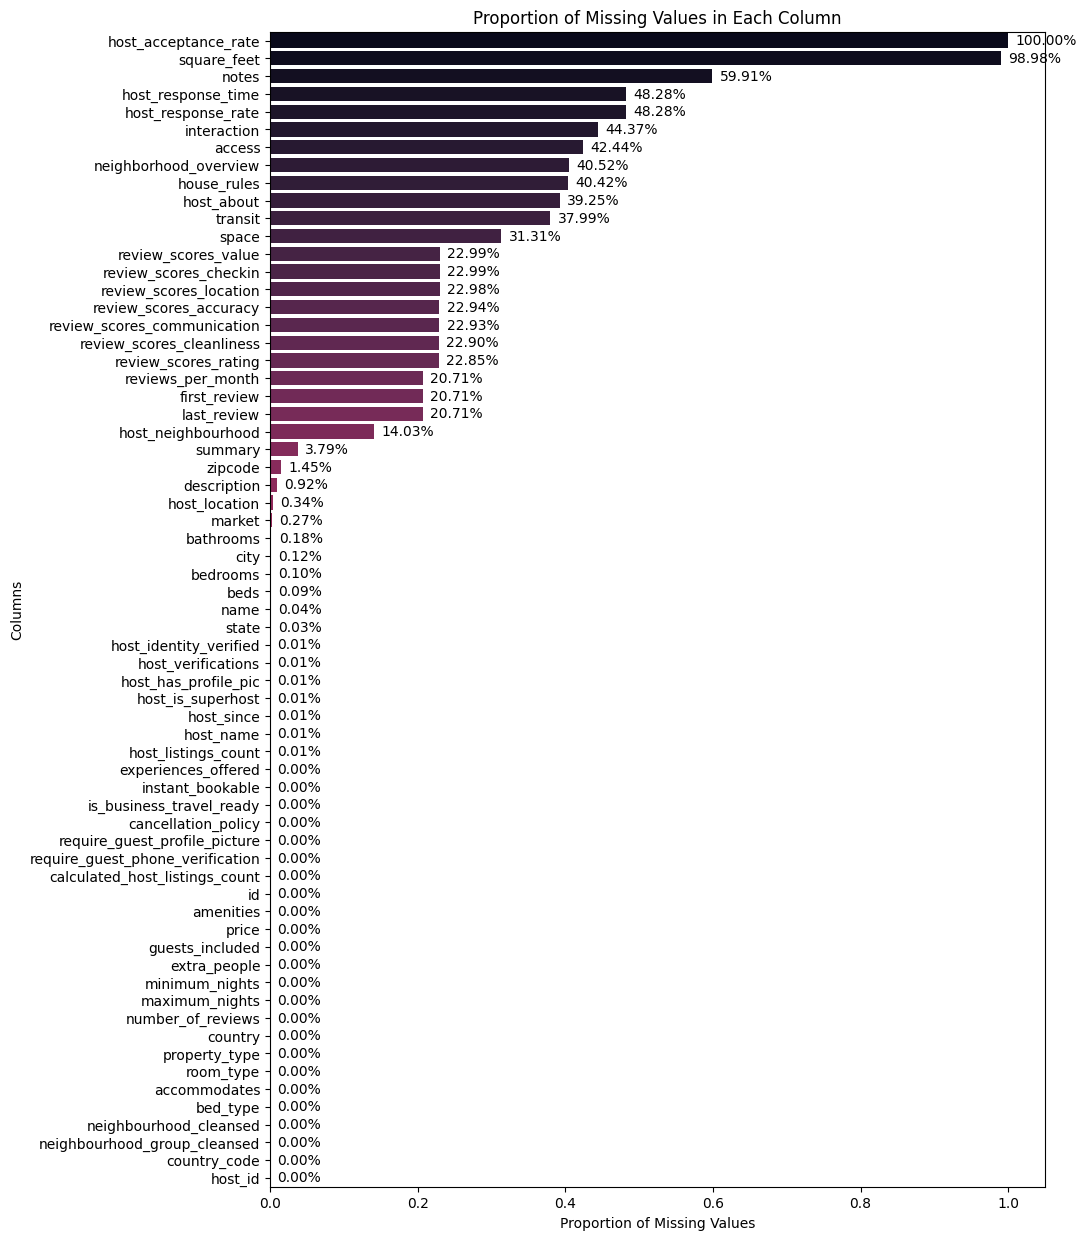

In [65]:
import seaborn as sns

# Find the proportion of values missing in each column
prop_missing = (df.isna().sum()/df.shape[0]).sort_values(ascending=False)
# Create a new series removing all features with no missing values
prop_missing_short = prop_missing[prop_missing > 0]
# Features with missing values
features_with_na = prop_missing_short.index

# Create horizontal bar plot of the proportion of missing values for each feature
# that has missing values.
plt.figure(figsize=(10, 15))
sns.barplot(x=prop_missing, y=prop_missing.index, palette='rocket')

# Annotate each bar with its corresponding value
for i, v in enumerate(prop_missing):
    plt.text(v + 0.01, i, f'{v*100:.2f}%', va='center')

plt.title('Proportion of Missing Values in Each Column')
plt.xlabel('Proportion of Missing Values')
plt.ylabel('Columns')
plt.show()


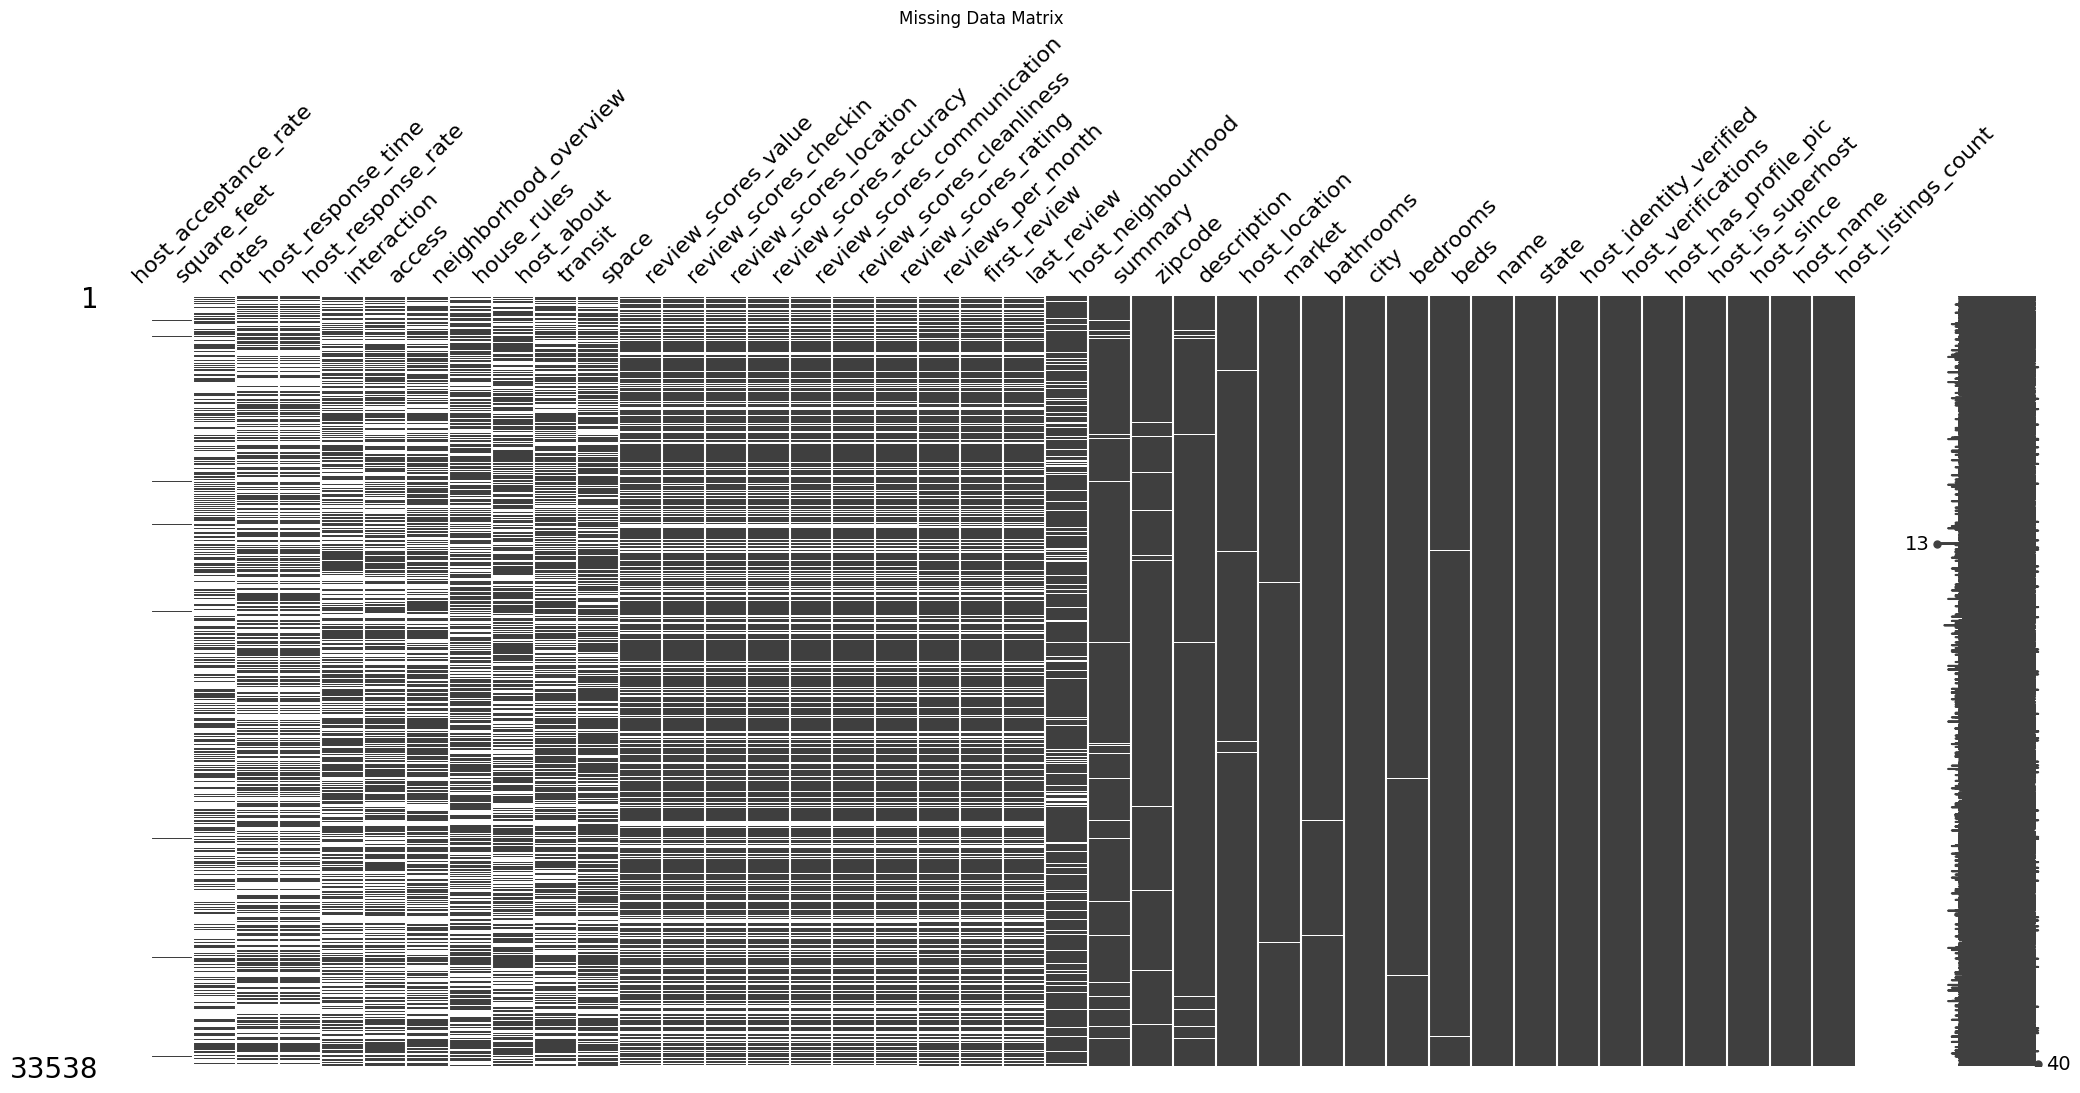

In [51]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df[features_with_na])
plt.title('Missing Data Matrix')
plt.show()

host_acceptance_rate seems to be null for every value, so it should be removed from our cleaned set. 

In [194]:
df_cleaned = df_cleaned.drop('host_acceptance_rate', axis=1)
df_cleaned.columns.shape[0]

58

Before we move on let's take a closer look at the experiences_offered feature. There don't seem to be any null values but what happens if we take a closer look. 

In [343]:
df.experiences_offered

0        none
1        none
2        none
3        none
4        none
         ... 
33533    none
33534    none
33535    none
33536    none
33537    none
Name: experiences_offered, Length: 33538, dtype: object

In [345]:
# Checks what proportion of experiences offered are none
df.experiences_offered.apply(lambda x: 1 if x=='none' else 0).sum()/df.shape[0]

1.0

All the experiences_offered are none so we will remove this feature.

In [347]:
df_cleaned = df_cleaned.drop('experiences_offered', axis=1)

#### Hypothesis Test for Square Feet and Related Features

Before removing square feet as a feature let's fist test whether or not the presence of nulls could indicate anything about the price distribution. In other words, is the price distribution of Airbnbs with square footage listed different from that of ones whare it is left null. If the distributions are different it might be worth keeping the feature. 

<Axes: ylabel='Frequency'>

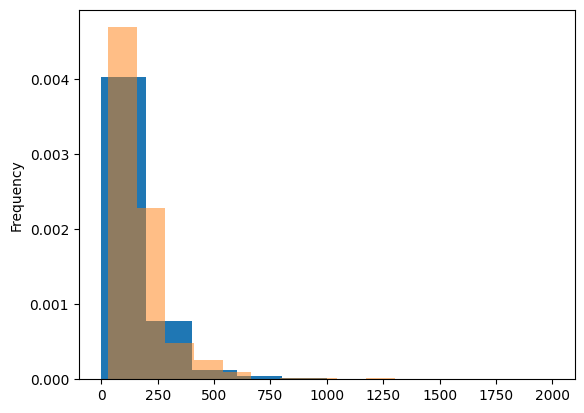

In [187]:
price_with_sq_feet = df[~df.square_feet.isna()].price
price_no_sq_feet = df[df.square_feet.isna()].price
price_no_sq_feet.plot(kind='hist', density=True)
price_with_sq_feet.plot(kind='hist', density=True, alpha=0.5)

The distributions look pretty similar, but lets do our due diligence and make a hypothesis test.

$H_0$: the two samples come from the same distribution.

$H_a$: they come from different distributions.

In [193]:
from scipy.stats import ks_2samp, anderson_ksamp

# Perform Kolmogorov-Smirnov test
ks_statistic, ks_pvalue = ks_2samp(price_no_sq_feet, price_with_sq_feet)
print("Kolmogorov-Smirnov Test:")
print("KS Statistic:", ks_statistic)
print("P-value:", ks_pvalue)

Kolmogorov-Smirnov Test:
KS Statistic: 0.18793124877817724
P-value: 6.327393544679208e-11


With a p-value that small we certaily will reject the null. Since they do come from different distributions we may as well keep the feature, but convert it to a true false value. 

In [195]:
# Perform Kolmogorov-Smirnov test
ks_statistic, ks_pvalue = ks_2samp(df[~df.notes.isna()].price, df[df.notes.isna()].price)
print("Kolmogorov-Smirnov Test:")
print("KS Statistic:", ks_statistic)
print("P-value:", ks_pvalue)

Kolmogorov-Smirnov Test:
KS Statistic: 0.03207094078359357
P-value: 1.2419212801886514e-07


Let's just run the same test on the features with missing values.

In [219]:
h_test_results = {
    'feature':[],
    'ks_pvalue':[],
    'ks_statistic':[],
    'prop_missing':[]
}

for feature in features_with_na[2:]:
    dist1 = df[df[feature].isna()].price
    dist2 = df[~df[feature].isna()].price
    ks_statistic, ks_pvalue = ks_2samp(dist1, dist2)
    h_test_results['feature'].append(feature)
    h_test_results['ks_pvalue'].append(ks_pvalue)
    h_test_results['ks_statistic'].append(ks_statistic)
    h_test_results['prop_missing'].append(prop_missing[feature])


h_test_results = pd.DataFrame(h_test_results)
h_test_results[h_test_results['ks_pvalue']>0.01]

,feature,ks_pvalue,ks_statistic,prop_missing
20,host_neighbourhood,0.044910,0.021618,0.140318
22,zipcode,0.055824,0.060824,0.014461
23,description,0.155107,0.064185,0.009184
24,host_location,0.299832,0.089707,0.003399
25,market,0.074900,0.133142,0.002684
29,beds,0.015891,0.272537,0.000924
30,name,0.672542,0.196748,0.000358
32,host_identity_verified,0.160291,0.468279,0.000149
33,host_verifications,0.160291,0.468279,0.000149
34,host_has_profile_pic,0.160291,0.468279,0.000149


In [218]:
h_test_results[h_test_results['ks_pvalue']<=0.01]

,feature,ks_pvalue,ks_statistic,prop_missing
0,notes,1.241921e-07,0.032071,0.599111
1,host_response_time,1.593736e-18,0.049847,0.482825
2,host_response_rate,1.593736e-18,0.049847,0.482825
3,interaction,3.582972e-09,0.034854,0.443676
4,access,3.325114e-22,0.055283,0.424414
5,neighborhood_overview,6.955013e-03,0.018693,0.405212
6,house_rules,1.825648e-03,0.020795,0.404168
7,host_about,4.105986e-03,0.019649,0.392510
8,transit,3.897617e-07,0.031245,0.379927
9,space,4.223541e-09,0.037183,0.313078


It seems like low p-values tend to mean higher rates of missingness within a feature. Lets plot a histogram of the missingness with for high p-vals ($> 0.01$) and low p-vals ($\leq 0.01$).

<Axes: ylabel='Frequency'>

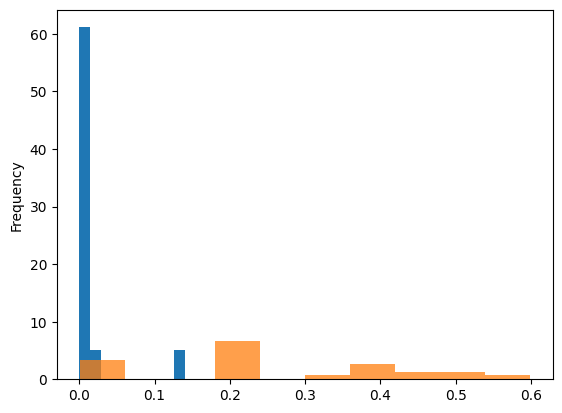

In [223]:
h_test_results[h_test_results['ks_pvalue']>0.01].prop_missing.plot(kind='hist', density='True')
h_test_results[h_test_results['ks_pvalue']<=0.01].prop_missing.plot(kind='hist', density='True', alpha=0.75)

Above we can see that the features with lower p-values seem to have a higher number of missing values, indicating that many of these features with lots of missing values could still provide useful information as TF values. With a few notable exceptions in each category. Perhapse we can split these features into four categories:

1. **High** p-value ($> 0.01$) and **high** missing prop ($> 5\%$)
* Indicates missingness does not inherently add information and that there are a lot of missing values making imputation difficult. Consider dropping features in this category.
2. **High** p-value ($> 0.01$) and **low** missing prop ($\leq 5\%$)
* Indicates that the missingness doesn't add information, but that there are not many missing values. We keep these because there is likely an effective way to impute the information that's missing.
3. **Low** p-value ($\leq 0.01$) and **high** missing prop ($> 5\%$)
* Indicates that missingness is adds information and that there are lots of missing values. These features can be kept and reduced to a binary variable. 
4. **Low** p-value ($\leq 0.01$) and **low** missing prop ($\leq 5\%$)
* Indicates that the missingness adds information and there are few missing values. These should be taken into account because it may change the way we would imput the missing values. 

In [245]:
high_p_high_m = h_test_results[(h_test_results['ks_pvalue']>0.01) & 
                               (h_test_results['prop_missing']>0.05)]
high_p_low_m = h_test_results[(h_test_results['ks_pvalue']>0.01) & 
                              (h_test_results['prop_missing']<=0.05)]
low_p_high_m = h_test_results[(h_test_results['ks_pvalue']<=0.01) & 
                              (h_test_results['prop_missing']>0.05)]
low_p_low_m = h_test_results[(h_test_results['ks_pvalue']<=0.01) & 
                             (h_test_results['prop_missing']<=0.05)]


,feature,ks_pvalue,ks_statistic,prop_missing
0,notes,1.241921e-07,0.032071,0.599111
1,host_response_time,1.593736e-18,0.049847,0.482825
2,host_response_rate,1.593736e-18,0.049847,0.482825
3,interaction,3.582972e-09,0.034854,0.443676
4,access,3.325114e-22,0.055283,0.424414
5,neighborhood_overview,6.955013e-03,0.018693,0.405212
6,house_rules,1.825648e-03,0.020795,0.404168
7,host_about,4.105986e-03,0.019649,0.392510
8,transit,3.897617e-07,0.031245,0.379927
9,space,4.223541e-09,0.037183,0.313078


<Axes: ylabel='Frequency'>

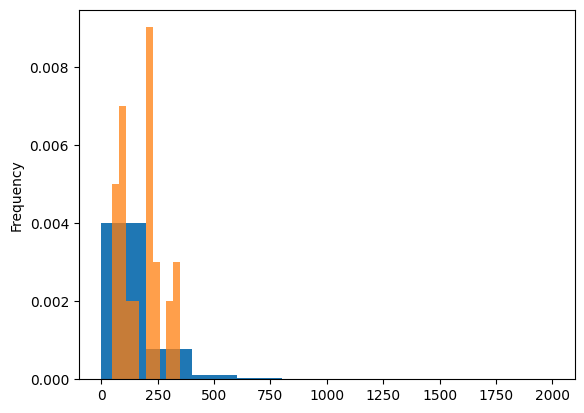

In [244]:
df[~df['bedrooms'].isna()].price.plot(kind='hist', density='true')
df[df['bedrooms'].isna()].price.plot(kind='hist', density='true', alpha=0.75)

#### Checking Numeric

In [249]:
only_numeric = df[numeric_features]


,id,host_id,host_acceptance_rate,host_listings_count,accommodates,bathrooms,bedrooms,beds,square_feet,price,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
0,22267382,1910170,NaN,1.0,2,1.0,1.0,1.0,NaN,145.0,...,6,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0.59
1,2473861,8826175,NaN,4.0,8,1.0,3.0,5.0,NaN,175.0,...,137,91.0,9.0,9.0,9.0,9.0,9.0,9.0,3,2.47
2,25079703,4383563,NaN,1.0,2,1.0,0.0,1.0,NaN,180.0,...,3,100.0,10.0,9.0,9.0,10.0,10.0,10.0,1,0.89
3,9342478,10406276,NaN,1.0,1,1.0,1.0,1.0,NaN,42.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
4,4866426,2346300,NaN,1.0,2,1.0,1.0,1.0,NaN,80.0,...,144,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,3.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33533,3958032,2667007,NaN,1.0,2,1.0,1.0,1.0,NaN,110.0,...,19,87.0,9.0,8.0,9.0,9.0,9.0,8.0,1,0.44
33534,7987209,42154621,NaN,3.0,8,3.0,4.0,4.0,NaN,1195.0,...,86,95.0,10.0,9.0,10.0,10.0,10.0,9.0,1,2.28
33535,796128,2286764,NaN,1.0,1,NaN,1.0,1.0,NaN,50.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
33536,17281121,17713747,NaN,4.0,2,1.0,1.0,1.0,NaN,60.0,...,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,3,0.10


## Initial Feature Selection

In [248]:
for c in df_cleaned.columns:
    print(c)

name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
host_id
host_since
host_location
host_about
host_response_time
host_response_rate
host_is_superhost
host_neighbourhood
host_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
neighbourhood_cleansed
neighbourhood_group_cleansed
city
zipcode
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
guests_included
extra_people
minimum_nights
maximum_nights
number_of_reviews
first_review
last_review
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
instant_bookable
is_business_travel_ready
cancellation_policy
require_guest_profile_picture
require_guest_phone_verification
calculated_host_listings_count
reviews_per_month
